# Polynomial Regression vs. Random Forest

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.table import Table, vstack, hstack, join
from astropy.io import fits
import fitsio
from scipy import stats

import sys, os, warnings

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict, train_test_split, KFold
from sklearn.metrics import median_absolute_error, mean_absolute_error, r2_score


In [2]:
cat = Table(fitsio.read('/global/cfs/cdirs/desi/spectro/redux/daily/exposures-daily.fits'))
mask = cat['SURVEY']=='main'
mask &= cat['PROGRAM']=='dark'
mask &= cat['EFFTIME_ETC']>100
mask &= cat['EFFTIME_SPEC']>100
mask &= cat['MJD'] != 0
cat = cat[mask]

### Define inputs and target variable

In [3]:
X = np.column_stack([
cat['EBV'],
cat['SEEING_ETC'],
# note: transparency was to be included, but the etc data is inaccesible and the feature did not have much importance in the random forest
    # add error to below features
cat['SKY_MAG_G_SPEC']-cat['SKY_MAG_R_SPEC'],
cat['SKY_MAG_R_SPEC'] # need to find etc data 
])
y = np.column_stack([cat['EFFTIME_SPEC']/cat['EFFTIME_ETC']])
y = np.ravel(y)

# 5 Fold Cross Validation

In [4]:
n_folds = 5
#kf createst the folds
kf = KFold(n_splits=n_folds, shuffle=True, random_state=1456)
np.random.seed(123)
predf = np.zeros(len(X))
y_pred2 = np.zeros(len(X))
y_pred3 = np.zeros(len(X))

for kf_index, (idx_train, idx_test) in enumerate(kf.split(X)):
# there's a different idx_train and idx_test for each fold
    print('Fold %d'%(kf_index+1))
    
    ###############################################
    # Random Forest Train/Test
    regrf = RandomForestRegressor(n_estimators=50, max_depth=50, random_state=1456, n_jobs=4)
    regrf.fit(X[idx_train], y[idx_train])
    predf[idx_test] = regrf.predict(X[idx_test])
    ###############################################
    # Scale the data
    
    scaler = StandardScaler()
    X_train_scaler = scaler.fit_transform(X[idx_train])
    X_test_scaler = scaler.transform(X[idx_test])
    
    y_train = y[idx_train]

    ###############################################
    # 2nd Order Poly Train/Test
    poly2 = PolynomialFeatures(2)
    polylist2 = PolynomialFeatures(2) # this is a separate poly model trained on the original features before the transform so we can get the names of all the coefficients
    # need Linear Regression for polynomial features to work
    lin2 = LinearRegression()
    X_poly_train2 = poly2.fit_transform(X_train_scaler) # fits and transforms the training data
    X_test_poly2 = poly2.transform(X_test_scaler)
    poly2.fit(X_poly_train2, y_train)
    lin2.fit(X_poly_train2, y_train)
    y_pred2[idx_test] = lin2.predict(X_test_poly2)
    
    ###############################################
    # 3rd Order Poly Train/Test
    poly3 = PolynomialFeatures(3)
    polylist3 = PolynomialFeatures(3) # this is a separate poly model trained on the original features before the transform so we can get the names of all the coefficients
    # need Linear Regression for polynomial features to work
    lin3 = LinearRegression()
    X_poly_train3 = poly3.fit_transform(X_train_scaler) # fits and transforms the training data
    X_test_poly3 = poly3.transform(X_test_scaler)
    poly3.fit(X_poly_train3, y_train)
    lin3.fit(X_poly_train3, y_train)
    y_pred3[idx_test] = lin3.predict(X_test_poly3)
    

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


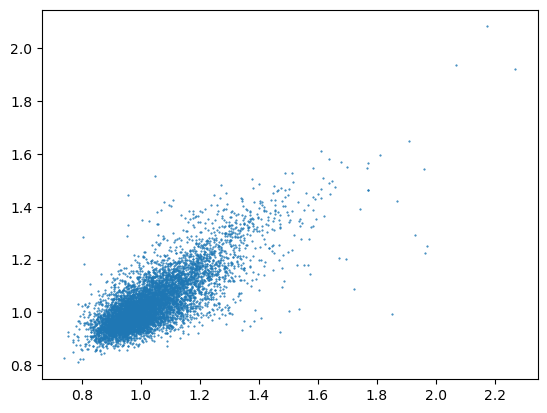

In [5]:
plt.plot(y, predf, '.', ms=1)

In [6]:
lin2.predict(X_test_poly2)

array([1.01807632, 0.9301747 , 1.12182058, ..., 0.95441313, 0.95923856,
       0.88968738])

In [7]:
regrf.predict(X[idx_test])
print(median_absolute_error(y[idx_test], y_pred2[idx_test]))
print(median_absolute_error(y[idx_test], y_pred3[idx_test]))
print(median_absolute_error(y[idx_test], predf[idx_test]))


0.048169584921502695
0.047901974068679576
0.04524478630876427


# 2nd Order Comparison

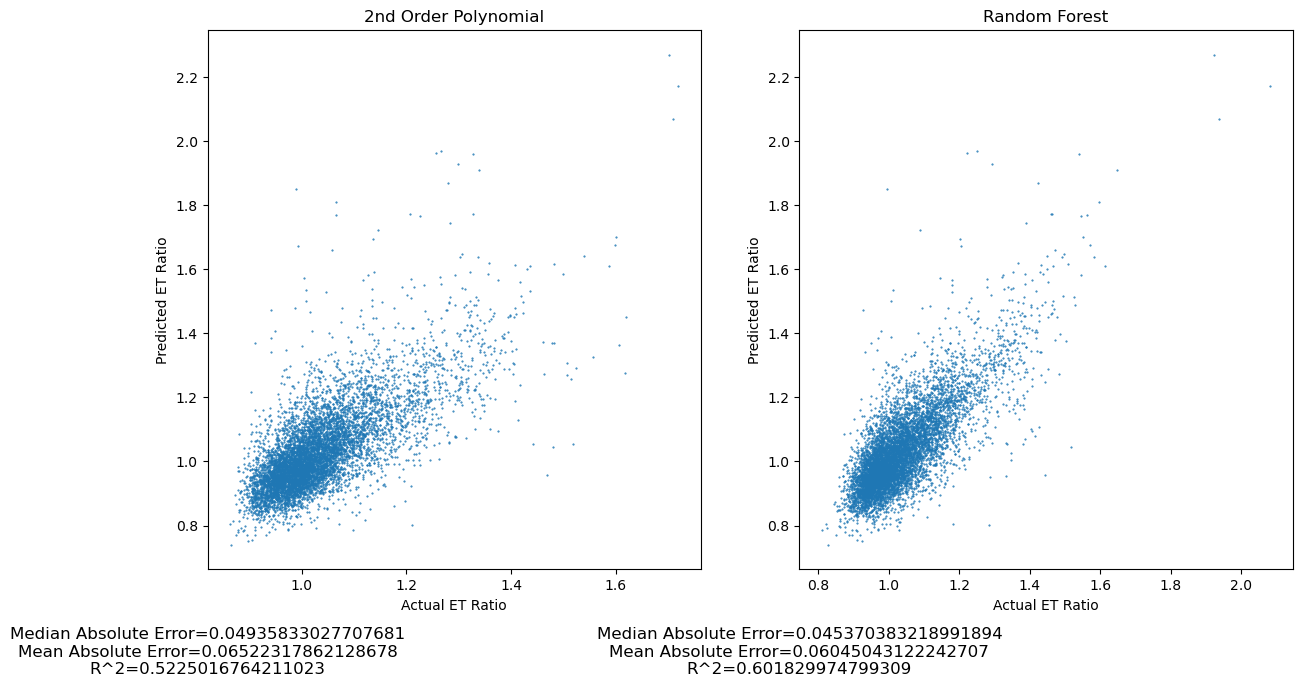

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(14,7))
y_test = y
ax[0].plot(y_pred2, y_test, '.', ms=1)
ax[0].set_title('2nd Order Polynomial')
ax[0].set_xlabel('Actual ET Ratio')
ax[0].set_ylabel('Predicted ET Ratio')

ax[1].plot(predf, y_test, '.', ms=1)
ax[1].set_title("Random Forest")
ax[1].set_xlabel('Actual ET Ratio')
ax[1].set_ylabel('Predicted ET Ratio')

text0='Median Absolute Error='+str(median_absolute_error(y_test,y_pred2))+'\n'+'Mean Absolute Error='+str(mean_absolute_error(y_test, y_pred2))+'\n'+'R^2='+str(r2_score(y_test, y_pred2))
text1='Median Absolute Error='+str(median_absolute_error(y_test,predf))+'\n'+'Mean Absolute Error='+str(mean_absolute_error(y_test, predf))+'\n'+'R^2='+str(r2_score(y_test, predf))


ax[0].text(0, -0.2, text0, horizontalalignment='center', verticalalignment='bottom', transform=ax[0].transAxes, fontsize='large')
ax[1].text(0, -0.2, text1, horizontalalignment='center', verticalalignment='bottom', transform=ax[1].transAxes, fontsize='large')


plt.show()

# 3rd Order Comparison

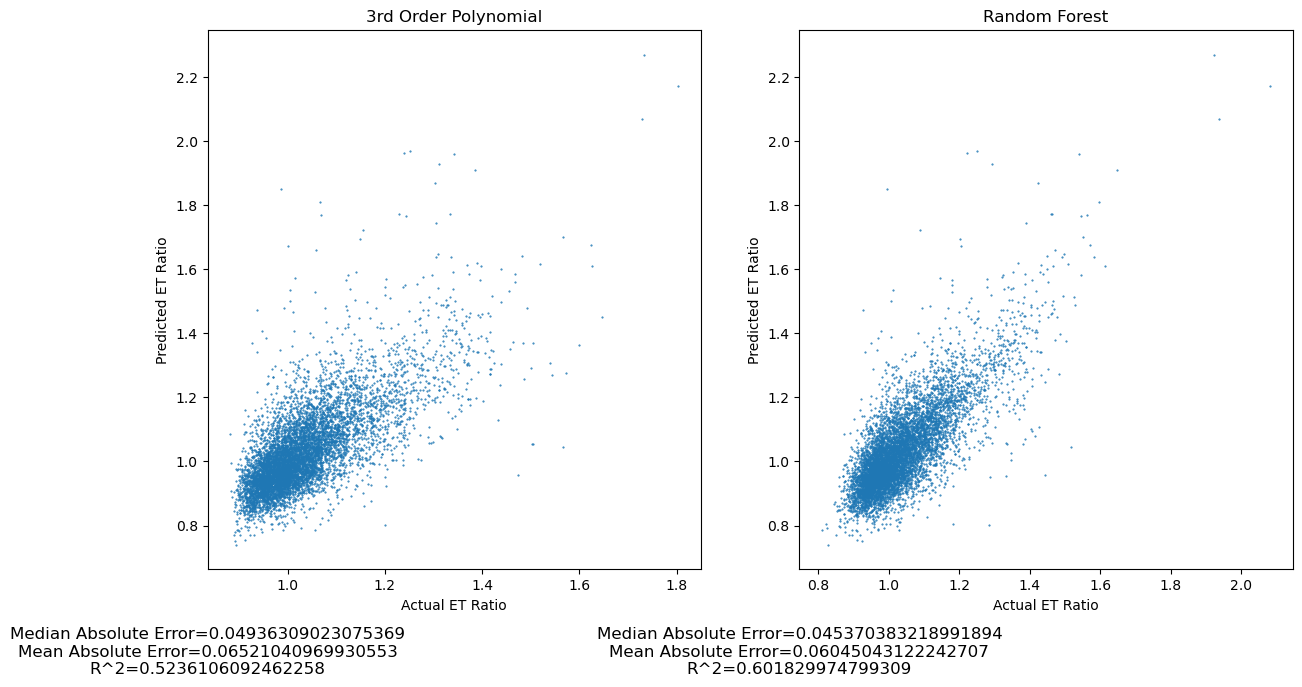

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(14,7))

ax[0].plot(y_pred3, y_test, '.', ms=1)
ax[0].set_title('3rd Order Polynomial')
ax[0].set_xlabel('Actual ET Ratio')
ax[0].set_ylabel('Predicted ET Ratio')

ax[1].plot(predf, y_test, '.', ms=1)
ax[1].set_title("Random Forest")
ax[1].set_xlabel('Actual ET Ratio')
ax[1].set_ylabel('Predicted ET Ratio')

text0='Median Absolute Error='+str(median_absolute_error(y_test,y_pred3))+'\n'+'Mean Absolute Error='+str(mean_absolute_error(y_test, y_pred3))+'\n'+'R^2='+str(r2_score(y_test, y_pred3))
text1='Median Absolute Error='+str(median_absolute_error(y_test,predf))+'\n'+'Mean Absolute Error='+str(mean_absolute_error(y_test, predf))+'\n'+'R^2='+str(r2_score(y_test, predf))


ax[0].text(0, -0.2, text0, horizontalalignment='center', verticalalignment='bottom', transform=ax[0].transAxes, fontsize='large')
ax[1].text(0, -0.2, text1, horizontalalignment='center', verticalalignment='bottom', transform=ax[1].transAxes, fontsize='large')


plt.show()

# 2nd vs. 3rd Order Comparison

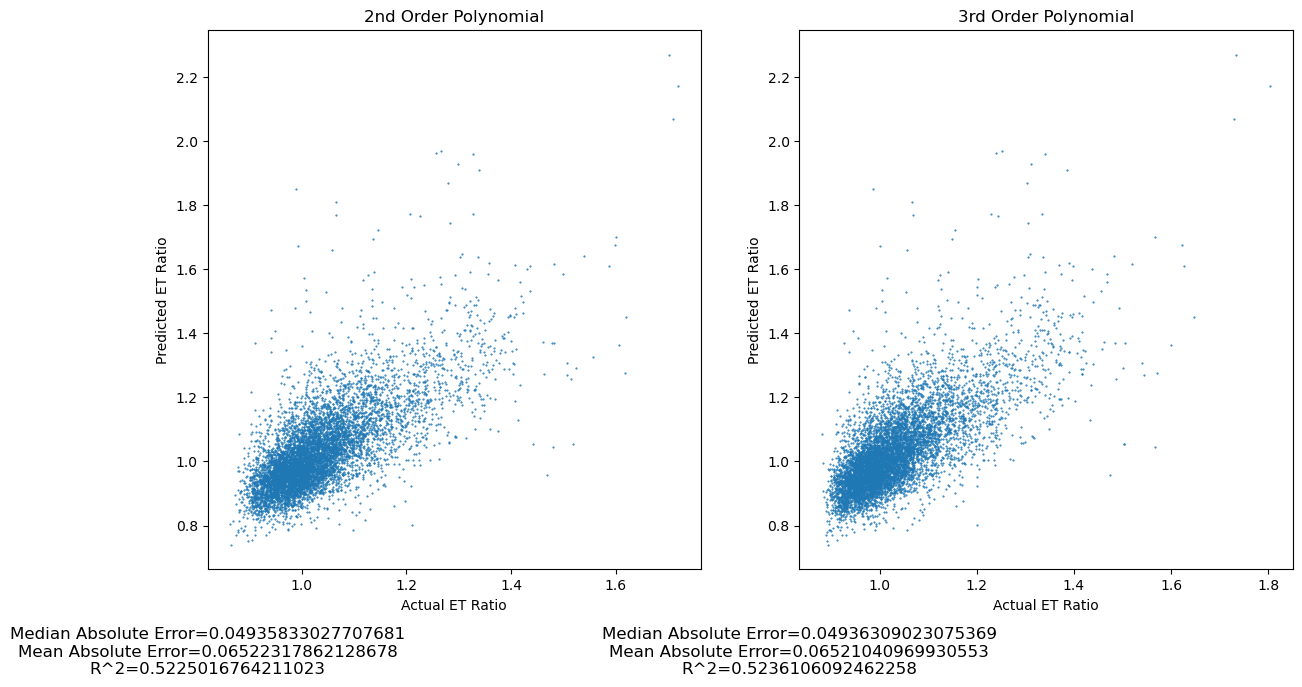

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(14,7))

ax[0].plot(y_pred2, y_test, '.', ms=1)
ax[0].set_title('2nd Order Polynomial')
ax[0].set_xlabel('Actual ET Ratio')
ax[0].set_ylabel('Predicted ET Ratio')

ax[1].plot(y_pred3, y_test, '.', ms=1)
ax[1].set_title('3rd Order Polynomial')
ax[1].set_xlabel('Actual ET Ratio')
ax[1].set_ylabel('Predicted ET Ratio')

text0='Median Absolute Error='+str(median_absolute_error(y_test,y_pred2))+'\n'+'Mean Absolute Error='+str(mean_absolute_error(y_test, y_pred2))+'\n'+'R^2='+str(r2_score(y_test, y_pred2))
text1='Median Absolute Error='+str(median_absolute_error(y_test,y_pred3))+'\n'+'Mean Absolute Error='+str(mean_absolute_error(y_test, y_pred3))+'\n'+'R^2='+str(r2_score(y_test, y_pred3))


ax[0].text(0, -0.2, text0, horizontalalignment='center', verticalalignment='bottom', transform=ax[0].transAxes, fontsize='large')
ax[1].text(0, -0.2, text1, horizontalalignment='center', verticalalignment='bottom', transform=ax[1].transAxes, fontsize='large')



plt.show()

# Corrections made with Polynomial Models

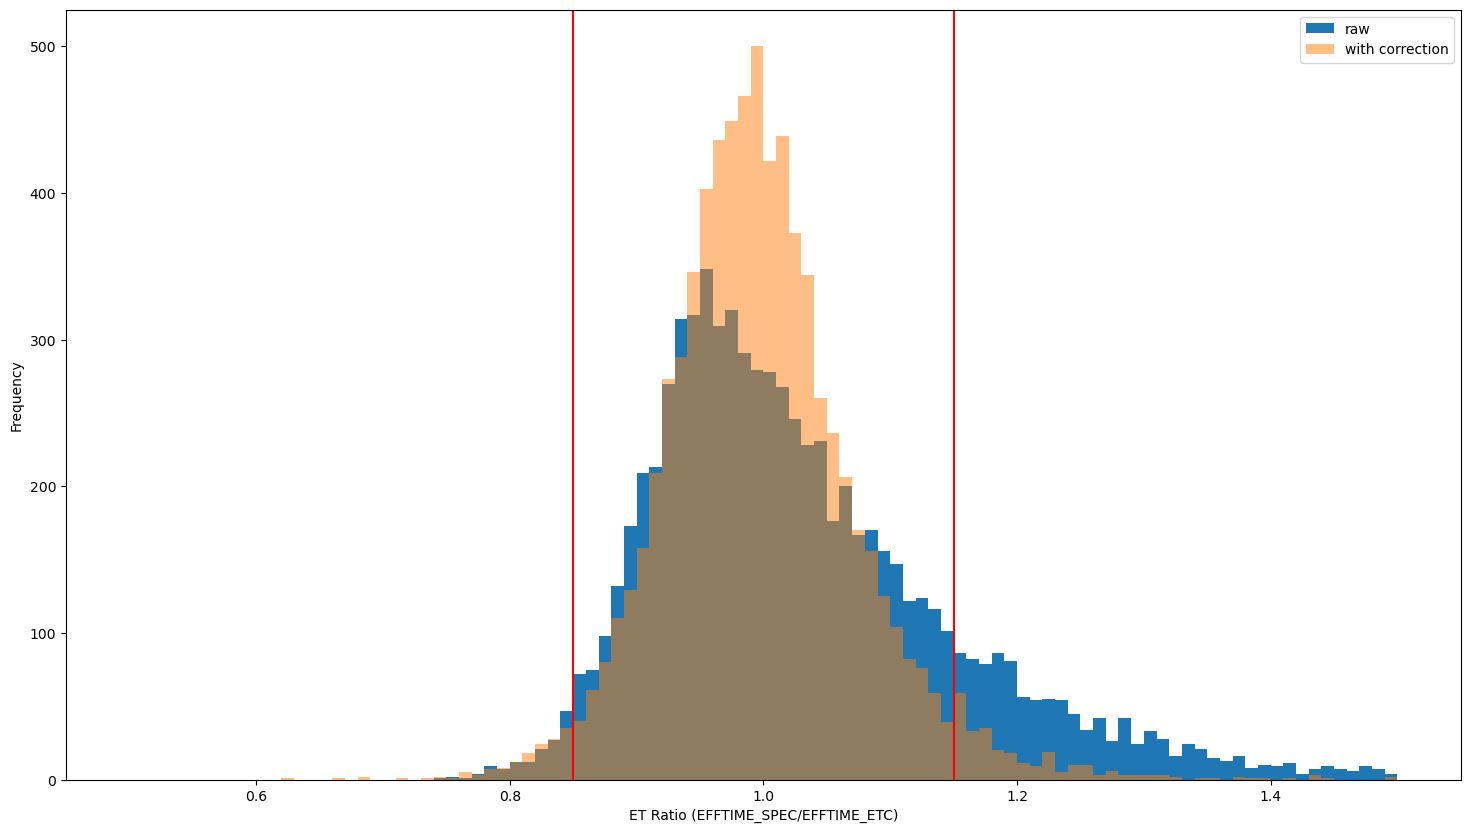

In [11]:


plt.figure(figsize=(18, 10))

plt.hist(y,bins = 100,range=(0.5,1.5));
plt.hist(y/predf,bins = 100,range=(0.5,1.5), alpha = 0.5);
plt.legend(['raw', 'with correction'])
plt.axvline(0.85, color='r')
plt.axvline(1.15, color='r')


plt.xlabel('ET Ratio (EFFTIME_SPEC/EFFTIME_ETC)')
plt.ylabel('Frequency')

plt.show()